In [1]:
## Enable matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

## Imports
import pandas as pd
pd.set_option('mode.chained_assignment',None)
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import numpy as np
from sklearn import ensemble
from sklearn import metrics

import mytools

In [2]:
## Read in the training and testing datasets
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

In [3]:
## Pass the datasets to the splitters
train_splt = mytools.Splitter(train_df)
test_splt  = mytools.Splitter(test_df)

In [4]:
polarized_df         = train_splt.polarized()
basic_df             = train_splt.basic()
null_df              = train_splt.null()
partial_basic_df     = train_splt.partial_basic()
partial_polarized_df = train_splt.partial_polarized()

In [5]:
n_complete = len(train_df)

n_polarized = len(polarized_df)
print 'Polarized DF         :', n_polarized, '({:.2%})'.format(float(n_polarized)/n_complete)

n_basic = len(basic_df)
print 'Basic DF             :', n_basic, '({:.2%})'.format(float(n_basic)/n_complete)

n_null = len(null_df)
print 'Null DF              :', n_null, '({:.2%})'.format(float(n_null)/n_complete)

n_partial_basic = len(partial_basic_df)
print 'Partial Basic DF     :', n_partial_basic, '({:.2%})'.format(float(n_partial_basic)/n_complete)

n_partial_polarized = len(partial_polarized_df)
print 'Partial Polarized DF :', n_partial_polarized, '({:.2%})'.format(float(n_partial_polarized)/n_complete)

n_all = n_polarized + n_basic + n_null + n_partial_basic + n_partial_polarized
print 'Patched up DF        :', n_all, '({:.2%})'.format(float(n_all)/n_complete)

print 'Complete DF          :', n_complete

Polarized DF         : 1085817 (7.89%)
Basic DF             : 160618 (1.17%)
Null DF              : 4639872 (33.71%)
Partial Basic DF     : 1585333 (11.52%)
Partial Polarized DF : 6293561 (45.72%)
Patched up DF        : 13765201 (100.00%)
Complete DF          : 13765201


In [6]:
## Define convenient lists of columns
all_columns = [
    'Ref',
    'Ref_5x5_10th',
    'Ref_5x5_50th',
    'Ref_5x5_90th',
    'RefComposite',
    'RefComposite_5x5_10th',
    'RefComposite_5x5_50th',
    'RefComposite_5x5_90th',
    'RhoHV',
    'RhoHV_5x5_10th',
    'RhoHV_5x5_50th',
    'RhoHV_5x5_90th',
    'Zdr',
    'Zdr_5x5_10th',
    'Zdr_5x5_50th',
    'Zdr_5x5_90th',
    'Kdp',
    'Kdp_5x5_10th',
    'Kdp_5x5_50th',
    'Kdp_5x5_90th'
]

basic_columns = all_columns[:8]
polarized_columns = all_columns[8:]


## -------------------------------------------
def intervals(df):
    """
    Adds a column to the dataframe assigning a time interval for each entry
    """
    
    df['interval'] = df['minutes_past'].diff()
    
    ## Build two masks, to single out first and last rows of each group
    group_begin_mask = df['Id'].diff() != 0
    group_end_mask   = df['Id'].diff().shift(-1) != 0
    
    ## Patch the beginning entry of each group
    df['interval'][group_begin_mask] = df['minutes_past'][group_begin_mask]
    
    ## Patch the last entry of each group
    df['interval'][group_end_mask] = 60 + df['interval'][group_end_mask] - df['minutes_past'][group_end_mask]



cf = {
    'Ref' : (1.01, 1.19, 0.86),
    'RefComposite' : (1.01, 1.15, 0.87),
    'RhoHV' : (1.00, 1.05, 0.97)
}

## -------------------------------------------
def complete(df, columns=[]):
    """
    Completes the main variables using the distributions
    """
    
    for var in columns:
        df[var] = df[var].fillna(value=cf[var][0]*df['{0}_5x5_50th'.format(var)])
        df[var] = df[var].fillna(value=cf[var][1]*df['{0}_5x5_10th'.format(var)])
        df[var] = df[var].fillna(value=cf[var][2]*df['{0}_5x5_90th'.format(var)])

In [7]:
## ========================================
class Collapser:
    """
    A class to collapse the time series
    """

    ## -------------------------------------------
    def __init__(self, integrate=[], mean=all_columns, patch=[], super_integrate=False):
        """
        Constructor
        """

        self.integrate = integrate
        self.super_integrate = super_integrate
        self.mean = list(set(mean).difference(set(integrate)))
        self.patch = patch


    ## -------------------------------------------
    def collapse(self, df):
        """
        Collapse the time series for a dataset given the rules
        specified in the constructor
        """

        intervals(df)
        complete(df, self.patch)

        int_columns = []
        
        ## Multiply the quantities by the time intervals
        for var in self.integrate:
            name = 'Int_{0}'.format(var)
            df[name] = df['interval'] * df[var]
            int_columns.append(name)
            
        ## Different values need to be grouped in different ways
        try:
            expected  = df[['Id', 'Expected', 'radardist_km'] + self.mean]
        except KeyError:
            expected  = df[['Id', 'radardist_km'] + self.mean]
            
        expected  = expected.groupby('Id', as_index=False).mean()
    
        variables = df[['Id'] + int_columns]
        variables = variables.groupby('Id', as_index=False).sum()
        
        if self.super_integrate:
            if 'Ref' in self.integrate:
                variables['Int_Ref'] = variables['Int_Ref'] + \
                variables['Int_Ref_5x5_10th'] + \
                variables['Int_Ref_5x5_50th'] + \
                variables['Int_Ref_5x5_90th']
                
            if 'RefComposite' in self.integrate:
                variables['Int_RefComposite'] = variables['Int_Ref'] + \
                variables['Int_RefComposite_5x5_10th'] + \
                variables['Int_RefComposite_5x5_50th'] + \
                variables['Int_RefComposite_5x5_90th']
                
            if 'RhoHV' in self.integrate:
                variables['Int_RhoHV'] = variables['Int_Ref'] + \
                variables['Int_RhoHV_5x5_10th'] + \
                variables['Int_RhoHV_5x5_50th'] + \
                variables['Int_RhoHV_5x5_90th']
                
            if 'Zdr' in self.integrate:
                variables['Int_Zdr'] = variables['Int_Ref'] + \
                variables['Int_Zdr_5x5_10th'] + \
                variables['Int_Zdr_5x5_50th'] + \
                variables['Int_Zdr_5x5_90th']
                
            if 'Kdp' in self.integrate:
                variables['Int_Kdp'] = variables['Int_Ref'] + \
                variables['Int_Kdp_5x5_10th'] + \
                variables['Int_Kdp_5x5_50th'] + \
                variables['Int_Kdp_5x5_90th']
        
        ## transform the integrated values into average values
        for var in int_columns:
            if self.super_integrate:
                variables[var] = variables[var]/240.0
            else:
                variables[var] = variables[var]/60.0
            
        ## Rename columns to what they are supposed to be
        renamer = {}
        for original, int_name in zip(self.integrate, int_columns):
            renamer[int_name] = original
            
        variables.rename(columns=renamer, inplace=True)
            
            
        ## Merge back expected and variables
        return pd.merge(variables, expected, on='Id')

In [8]:
## ========================================
class BRTTrainer:
    """
    A class to train a Boosted Regression Trees
    """

    ## --------------------------------------------
    def __init__(self, train_df, variables=all_columns, max_depth=None, n_estimators=10, max_features=None, rf=True):
        """
        Constructor
        """

        self.train_df = train_df
        self.brt = None
        self.rf = rf
        self.variables = variables
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.max_features = max_features


    ## --------------------------------------------
    def train(self, clean=False, stuck_repeat=50, max_expected=100.0):
        """
        train the BRT
        """

        clean_df = self.train_df.fillna(-1111.0)

        if clean:
            clean_df = mytools.clean_stuck_gauges(clean_df, threshold=stuck_repeat)
            clean_df = clean_df[clean_df['Expected'] < max_expected]

        ## Extract numpy arrays to pass to scikit-learn for training
        train_data   = clean_df[['radardist_km'] + self.variables].values
        train_target = clean_df['Expected'].values

        ## Train the Boosted Regression trees
        if self.rf:
            self.brt = ensemble.RandomForestRegressor(max_depth=self.max_depth, n_estimators=self.n_estimators, random_state=24)
        else:
            self.brt = ensemble.GradientBoostingRegressor(max_depth=self.max_depth, n_estimators=self.n_estimators, max_features=self.max_features, random_state=24)
        self.brt.fit(train_data, train_target)


    ## ---------------------------------------------
    def predict(self, *args):
        """
        produce prediction
        """

        return self.brt.predict(args)[0]


    ## ---------------------------------------------
    def apply(self, df):
        """
        create a new prediction column for a dataset
        """

        clean_df = df.fillna(-1111.0)
        
        columns = [clean_df['radardist_km']]
        for var in self.variables:
            columns.append(clean_df[var])

        df['Prediction'] = map(self.predict, *columns)
        
        
    ## ---------------------------------------------
    def evaluate(self, df):
        """
        evaluate the performance of the predictions
        """
        
        return metrics.mean_absolute_error(df['Expected'].values, df['Prediction'].values)

In [9]:
## ---------------------------------------------
def find_min_di(test_df, trainer):
    """
    Finds the best score shift
    """
    min_score = 10000000.0
    min_di    = None

    for di in [0.001*i for i in range(1001)]:
        test_df['backup'] = test_df['Prediction']
        test_df['Prediction'] = test_df['Prediction'] - di
        score = trainer.evaluate(test_df)
        if score < min_score:
            min_score = score
            min_di = di
        test_df['Prediction'] = test_df['backup']
    
    return min_score, min_di

In [10]:
def correlation_plot(df, var1, var2, bounds = None):
    """
    produces a 2D histogram for a pair of variables
    """

    df_var1_nonan = df[~df[var1].isnull()]
    df_var2_nonan = df_var1_nonan[~df_var1_nonan[var2].isnull()]
    
    x = df_var2_nonan[var1].values
    y = df_var2_nonan[var2].values

    if bounds is None:
        xmin = x.min()
        xmax = x.max()
        ymin = y.min()
        ymax = y.max()
    else:
        
        (xmin, xmax, ymin, ymax) = bounds

    fig, ax = plt.subplots()

    ax.set_xlabel(var1)
    ax.set_ylabel(var2)

    plt.hist2d(x, y, cmap=plt.cm.YlOrRd_r, bins=[40,40], range=((xmin, xmax),(ymin, ymax)))
    plt.axis([xmin, xmax, ymin, ymax])

    return plt

# 1 - Polarized DF

In [11]:
polarized_collapser = Collapser(integrate=basic_columns, super_integrate=True)

In [12]:
polarized_collapsed_df = polarized_collapser.collapse(polarized_df)

In [13]:
split = len(polarized_collapsed_df)/2
train = polarized_collapsed_df[:split]
test  = polarized_collapsed_df[split:]

In [14]:
polarized_trainer = BRTTrainer(train, variables=all_columns, max_depth=3, n_estimators=200, rf=False)
polarized_trainer.train(clean=True, stuck_repeat=10, max_expected=20.0)

In [15]:
polarized_trainer.apply(test)
polarized_trainer.evaluate(test)

10.146449621934311

In [16]:
min_score, min_di = find_min_di(test, polarized_trainer)
print min_score, min_di

10.1072473288 0.439


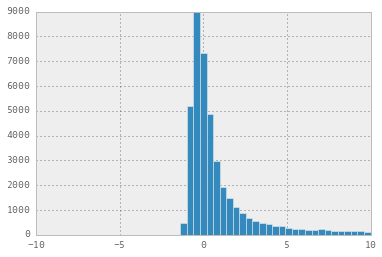

0.228008315135


In [17]:
resolution = (test['Prediction'] - test['Expected'])/test['Expected']
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
print resolution.median()

In [18]:
test['Prediction'] = test['Prediction'] - min_di

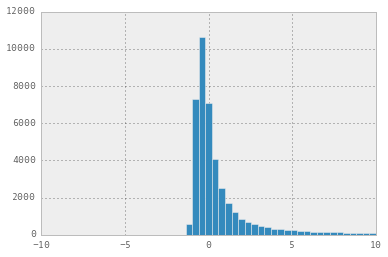

-0.00033836225406


In [19]:
resolution = (test['Prediction'] - test['Expected'])/test['Expected']
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
print resolution.median()

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

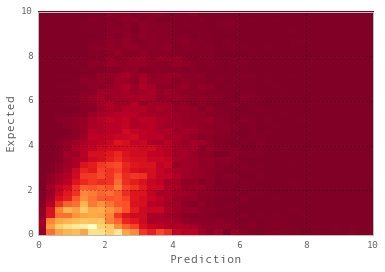

In [20]:
correlation_plot(test, 'Prediction', 'Expected', bounds = (0,10,0,10))

In [21]:
polarized_trainer = BRTTrainer(polarized_collapsed_df, variables=all_columns, max_depth=3, n_estimators=200, rf=False)
polarized_trainer.train(clean=True, stuck_repeat=10, max_expected=20.0)

In [22]:
test_polarized_collapsed_df = polarized_collapser.collapse(test_splt.polarized())

In [23]:
polarized_trainer.apply(test_polarized_collapsed_df)
test_polarized_collapsed_df['Prediction'] = test_polarized_collapsed_df['Prediction'] - min_di

# 2 - Basic DF

In [24]:
basic_collapser = Collapser(integrate=basic_columns, super_integrate=True)

In [25]:
basic_collapsed_df = basic_collapser.collapse(basic_df)

In [26]:
split = len(basic_collapsed_df)/2
train = basic_collapsed_df[:split]
test  = basic_collapsed_df[split:]

In [27]:
basic_trainer = BRTTrainer(train, variables=basic_columns, max_depth=3, n_estimators=100, rf=False)
basic_trainer.train(clean=True, stuck_repeat=10, max_expected=30.0)

In [28]:
basic_trainer.apply(test)
basic_trainer.evaluate(test)

15.419431051322885

In [29]:
min_score, min_di = find_min_di(test, basic_trainer)
print min_score, min_di

15.3890832465 0.488


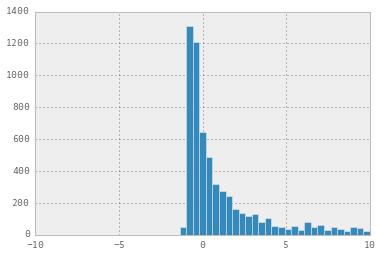

0.247590693819


In [30]:
resolution = (test['Prediction'] - test['Expected'])/test['Expected']
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
print resolution.median()

In [31]:
test['Prediction'] = test['Prediction'] - min_di

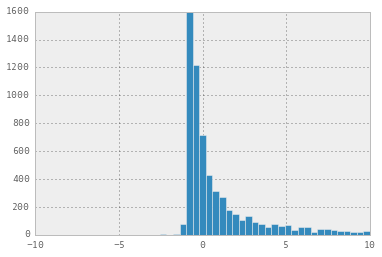

2.83027041625e-05


In [32]:
resolution = (test['Prediction'] - test['Expected'])/test['Expected']
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
print resolution.median()

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

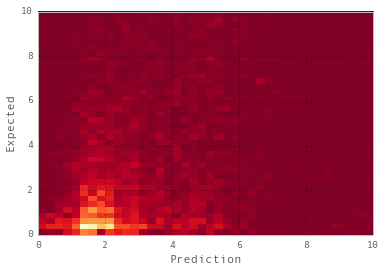

In [33]:
correlation_plot(test, 'Prediction', 'Expected', bounds = (0,10,0,10))

In [34]:
basic_trainer = BRTTrainer(basic_collapsed_df, variables=basic_columns, max_depth=3, n_estimators=100, rf=False)
basic_trainer.train(clean=True, stuck_repeat=10, max_expected=30.0)

In [35]:
test_basic_collapsed_df = basic_collapser.collapse(test_splt.basic())

In [36]:
basic_trainer.apply(test_basic_collapsed_df)
test_basic_collapsed_df['Prediction'] = test_basic_collapsed_df['Prediction'] - min_di

# 3 - Null DF

In [37]:
null_collapser = Collapser()
null_collapsed_df = null_collapser.collapse(null_df)

In [38]:
split = len(null_collapsed_df)/2
train = null_collapsed_df[:split]
test  = null_collapsed_df[split:]

In [39]:
test['Prediction'] = train['Expected'].median()

In [40]:
basic_trainer.evaluate(test)

304.61961855912733

In [41]:
test_null_collapsed_df = null_collapser.collapse(test_splt.null())
test_null_collapsed_df['Prediction'] = null_collapsed_df['Expected'].median()

# 4 - Partial Polarized DF

In [42]:
partial_polarized_collapser = Collapser(patch=['Ref', 'RefComposite'])

In [43]:
partial_polarized_collapsed_df = partial_polarized_collapser.collapse(partial_polarized_df)

In [44]:
split = len(partial_polarized_collapsed_df)/2
train = partial_polarized_collapsed_df[:split]
test  = partial_polarized_collapsed_df[split:]

In [45]:
partial_polarized_trainer = BRTTrainer(train, variables=all_columns, max_depth=3, n_estimators=300, rf=False)
partial_polarized_trainer.train(clean=True, stuck_repeat=100, max_expected=20.0)

In [46]:
partial_polarized_trainer.apply(test)
partial_polarized_trainer.evaluate(test)

20.596967694324004

In [47]:
min_score, min_di = find_min_di(test, basic_trainer)
print min_score, min_di

20.513794364 0.491


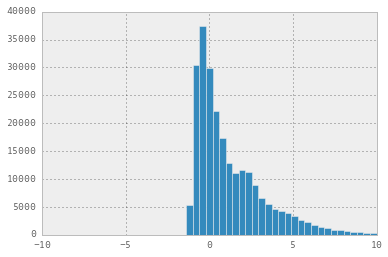

0.606682487478


In [48]:
resolution = (test['Prediction'] - test['Expected'])/test['Expected']
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
print resolution.median()

In [49]:
test['Prediction'] = test['Prediction'] - min_di

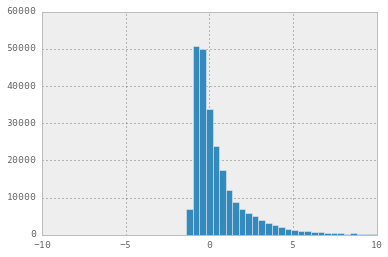

3.66393848519e-06


In [50]:
resolution = (test['Prediction'] - test['Expected'])/test['Expected']
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
print resolution.median()

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

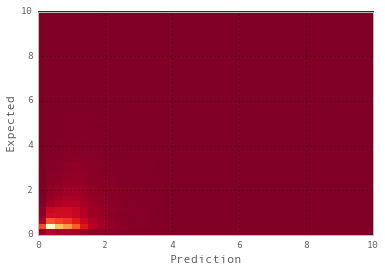

In [51]:
correlation_plot(test, 'Prediction', 'Expected', bounds = (0,10,0,10))

In [52]:
partial_polarized_trainer = BRTTrainer(partial_polarized_collapsed_df, variables=all_columns, max_depth=3, n_estimators=300, rf=False)
partial_polarized_trainer.train(clean=True, stuck_repeat=100, max_expected=20.0)

In [53]:
test_partial_polarized_collapsed_df = partial_polarized_collapser.collapse(test_splt.partial_polarized())

In [54]:
partial_polarized_trainer.apply(test_partial_polarized_collapsed_df)
test_partial_polarized_collapsed_df['Prediction'] = test_partial_polarized_collapsed_df['Prediction'] - min_di

# 5 - Partial Basic DF

In [55]:
partial_basic_collapser = Collapser(patch=['RefComposite'])

In [56]:
partial_basic_collapsed_df = partial_basic_collapser.collapse(partial_basic_df)

In [57]:
split = len(partial_basic_collapsed_df)/2
train = partial_basic_collapsed_df[:split]
test  = partial_basic_collapsed_df[split:]

In [58]:
partial_basic_trainer = BRTTrainer(train, variables=basic_columns, max_depth=3, n_estimators=300, rf=False)
partial_basic_trainer.train(clean=True, stuck_repeat=50, max_expected=20.0)

In [59]:
partial_basic_trainer.apply(test)
partial_basic_trainer.evaluate(test)

43.609755532604261

In [60]:
min_score, min_di = find_min_di(test, basic_trainer)
print min_score, min_di

43.5434734066 0.512


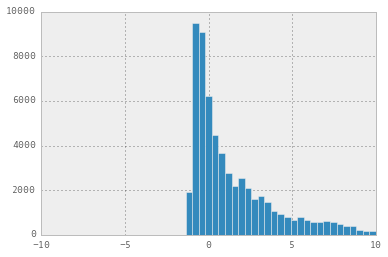

0.549102777589


In [61]:
resolution = (test['Prediction'] - test['Expected'])/test['Expected']
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
print resolution.median()

In [62]:
test['Prediction'] = test['Prediction'] - min_di

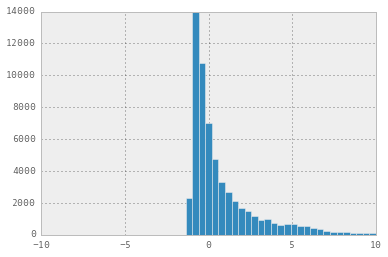

0.000710843096694


In [63]:
resolution = (test['Prediction'] - test['Expected'])/test['Expected']
hist, bins = np.histogram(resolution, bins=51, range=(-10,10))
width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
print resolution.median()

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

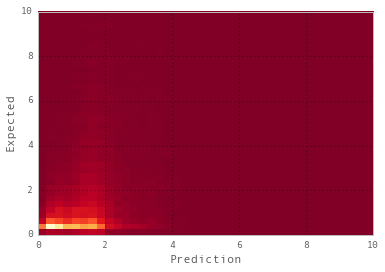

In [64]:
correlation_plot(test, 'Prediction', 'Expected', bounds = (0,10,0,10))

In [65]:
partial_basic_trainer = BRTTrainer(partial_basic_collapsed_df, variables=basic_columns, max_depth=3, n_estimators=300, rf=False)
partial_basic_trainer.train(clean=True, stuck_repeat=50, max_expected=20.0)

In [66]:
test_partial_basic_collapsed_df = partial_basic_collapser.collapse(test_splt.partial_basic())

In [67]:
partial_basic_trainer.apply(test_partial_basic_collapsed_df)
test_partial_basic_collapsed_df['Prediction'] = test_partial_basic_collapsed_df['Prediction'] - min_di

# 6 - Putting it all together

In [68]:
test_dfs = [
    test_polarized_collapsed_df,
    test_basic_collapsed_df,
    test_null_collapsed_df,
    test_partial_polarized_collapsed_df,
    test_partial_basic_collapsed_df
]

test_with_predictions = pd.concat(test_dfs)

In [69]:
len(test_with_predictions)

717625

In [70]:
test_with_predictions.sort_values(by=['Id'], inplace=True)

In [71]:
test_with_predictions.rename(columns={'Prediction' : 'Expected'}, inplace=True)

In [72]:
test_with_predictions[['Id', 'Expected']].to_csv('predictions13.csv', index=False)